🤖 NOTEBOOK 3: MODELING AND HYPERPARAMETER TUNING
📥 Loading preprocessed data...
Training set: (1176, 30)
Test set: (294, 30)
Training attrition rate: 16.16%

🎯 SETTING UP HYPERPARAMETER TUNING...

🚀 TRAINING MODELS WITH GRID SEARCH...
  🔹 Training Logistic Regression...
    ✅ Best params: {'C': 10, 'class_weight': {0: 1, 1: 2}, 'max_iter': 1000, 'solver': 'liblinear'}
    ✅ Best CV score: 0.5463
  🔹 Training Random Forest...
    ✅ Best params: {'class_weight': 'balanced_subsample', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
    ✅ Best CV score: 0.5298
  🔹 Training Gradient Boosting...
    ✅ Best params: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 150}
    ✅ Best CV score: 0.5332
  🔹 Creating Ensemble Model...
✅ All models trained and optimized

📊 QUICK PERFORMANCE CHECK ON TEST SET:
Model                AUC-PR   AUC-ROC 
----------------------------------------------------------------------
Logistic Regressio

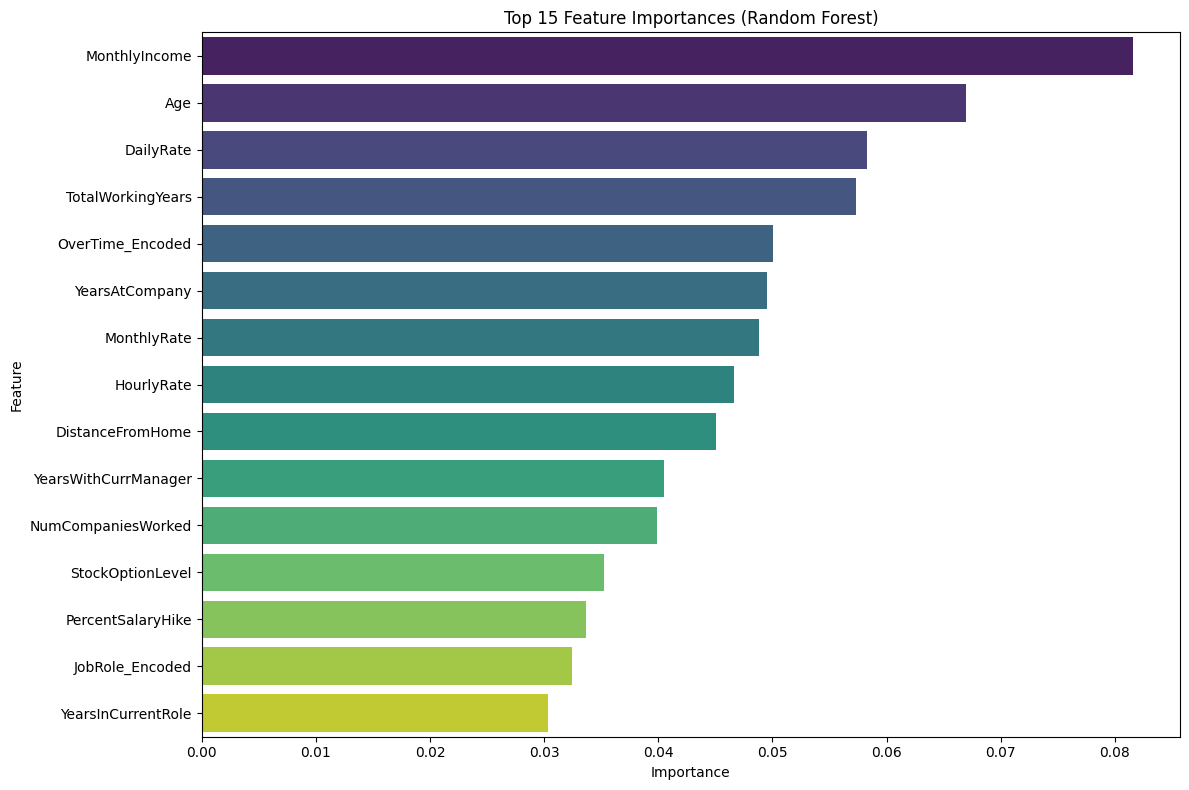


💾 SAVING TRAINED MODELS...
  ✅ Saved Logistic Regression as model_logistic_regression.pkl
  ✅ Saved Random Forest as model_random_forest.pkl
  ✅ Saved Gradient Boosting as model_gradient_boosting.pkl
  ✅ Saved Ensemble as model_ensemble.pkl
✅ Modeling and hyperparameter tuning completed successfully!


In [3]:
# =============================================================================
# NOTEBOOK 3: MODELING AND HYPERPARAMETER TUNING
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
import warnings
warnings.filterwarnings('ignore')

print("🤖 NOTEBOOK 3: MODELING AND HYPERPARAMETER TUNING")
print("=" * 50)

# Load preprocessed data
print("📥 Loading preprocessed data...")
X_train_scaled = joblib.load('X_train_scaled.pkl')
X_test_scaled = joblib.load('X_test_scaled.pkl')
y_train = joblib.load('y_train.pkl')
y_test = joblib.load('y_test.pkl')

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Training attrition rate: {(y_train.sum() / len(y_train) * 100):.2f}%")

# Define parameter grids for each model
print("\n🎯 SETTING UP HYPERPARAMETER TUNING...")

param_grids = {
    'logistic': {
        'C': [0.1, 1, 10],
        'class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}],
        'solver': ['liblinear'],
        'max_iter': [1000]
    },
    'random_forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'class_weight': ['balanced', 'balanced_subsample']
    },
    'gradient_boosting': {
        'n_estimators': [100, 150],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 4],
        'min_samples_split': [2, 5]
    }
}

# Train individual models with cross-validation
print("\n🚀 TRAINING MODELS WITH GRID SEARCH...")

models = {}
cv_scores = {}

# Logistic Regression
print("  🔹 Training Logistic Regression...")
lr = LogisticRegression(random_state=42)
lr_grid = GridSearchCV(lr, param_grids['logistic'], cv=5, scoring='average_precision', n_jobs=-1)
lr_grid.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr_grid.best_estimator_
cv_scores['Logistic Regression'] = lr_grid.best_score_
print(f"    ✅ Best params: {lr_grid.best_params_}")
print(f"    ✅ Best CV score: {lr_grid.best_score_:.4f}")

# Random Forest
print("  🔹 Training Random Forest...")
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, param_grids['random_forest'], cv=5, scoring='average_precision', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
models['Random Forest'] = rf_grid.best_estimator_
cv_scores['Random Forest'] = rf_grid.best_score_
print(f"    ✅ Best params: {rf_grid.best_params_}")
print(f"    ✅ Best CV score: {rf_grid.best_score_:.4f}")

# Gradient Boosting
print("  🔹 Training Gradient Boosting...")
gb = GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(gb, param_grids['gradient_boosting'], cv=5, scoring='average_precision', n_jobs=-1)
gb_grid.fit(X_train_scaled, y_train)
models['Gradient Boosting'] = gb_grid.best_estimator_
cv_scores['Gradient Boosting'] = gb_grid.best_score_
print(f"    ✅ Best params: {gb_grid.best_params_}")
print(f"    ✅ Best CV score: {gb_grid.best_score_:.4f}")

# Ensemble Model (Weighted Voting)
print("  🔹 Creating Ensemble Model...")
ensemble = VotingClassifier(
    estimators=[
        ('lr', models['Logistic Regression']),
        ('rf', models['Random Forest']),
        ('gb', models['Gradient Boosting'])
    ],
    voting='soft',
    weights=[cv_scores['Logistic Regression'], cv_scores['Random Forest'], cv_scores['Gradient Boosting']]
)

models['Ensemble'] = ensemble
models['Ensemble'].fit(X_train_scaled, y_train)

print("✅ All models trained and optimized")

# Quick performance check
print("\n📊 QUICK PERFORMANCE CHECK ON TEST SET:")
print("=" * 70)
print(f"{'Model':<20} {'AUC-PR':<8} {'AUC-ROC':<8}")
print("-" * 70)

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    auc_pr = average_precision_score(y_test, y_pred_proba)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    print(f"{name:<20} {auc_pr:.4f}  {auc_roc:.4f}")

print("=" * 70)

# Feature Importance Analysis
print("\n🔍 FEATURE IMPORTANCE ANALYSIS")

# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': models['Random Forest'].feature_importances_
}).sort_values('Importance', ascending=False)

print("🚀 TOP 10 FEATURES (Random Forest):")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"  {i:2d}. {row['Feature']}: {row['Importance']:.4f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save trained models
print("\n💾 SAVING TRAINED MODELS...")
for name, model in models.items():
    filename = f'model_{name.replace(" ", "_").lower()}.pkl'
    joblib.dump(model, filename)
    print(f"  ✅ Saved {name} as {filename}")

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)

print("✅ Modeling and hyperparameter tuning completed successfully!")

📊 NOTEBOOK 4: MODEL EVALUATION AND RISK ASSESSMENT
📥 Loading models and data...
  ✅ Loaded Logistic Regression
  ✅ Loaded Random Forest
  ✅ Loaded Gradient Boosting
  ✅ Loaded Ensemble
Test set: (294, 30)

🎯 COMPREHENSIVE MODEL EVALUATION
Evaluating Logistic Regression...
Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating Ensemble...

📈 MODEL PERFORMANCE COMPARISON:
Model                AUC-PR   AUC-ROC  Recall   Precision  F1-Score Accuracy
------------------------------------------------------------------------------------------
Logistic Regression  0.6098  0.8061  0.5532  0.5000    0.5253  0.8401
Random Forest        0.4049  0.7879  0.1277  0.3529    0.1875  0.8231
Gradient Boosting    0.4390  0.7933  0.1915  0.5625    0.2857  0.8469
Ensemble             0.5437  0.8170  0.3191  0.7143    0.4412  0.8707
🏆 BEST MODEL: Logistic Regression (AUC-PR: 0.6098)

🔍 DETAILED ANALYSIS OF BEST MODEL: Logistic Regression
🎯 KEY PERFORMANCE METRICS:
  • AUC-PR:        0.6098
  •

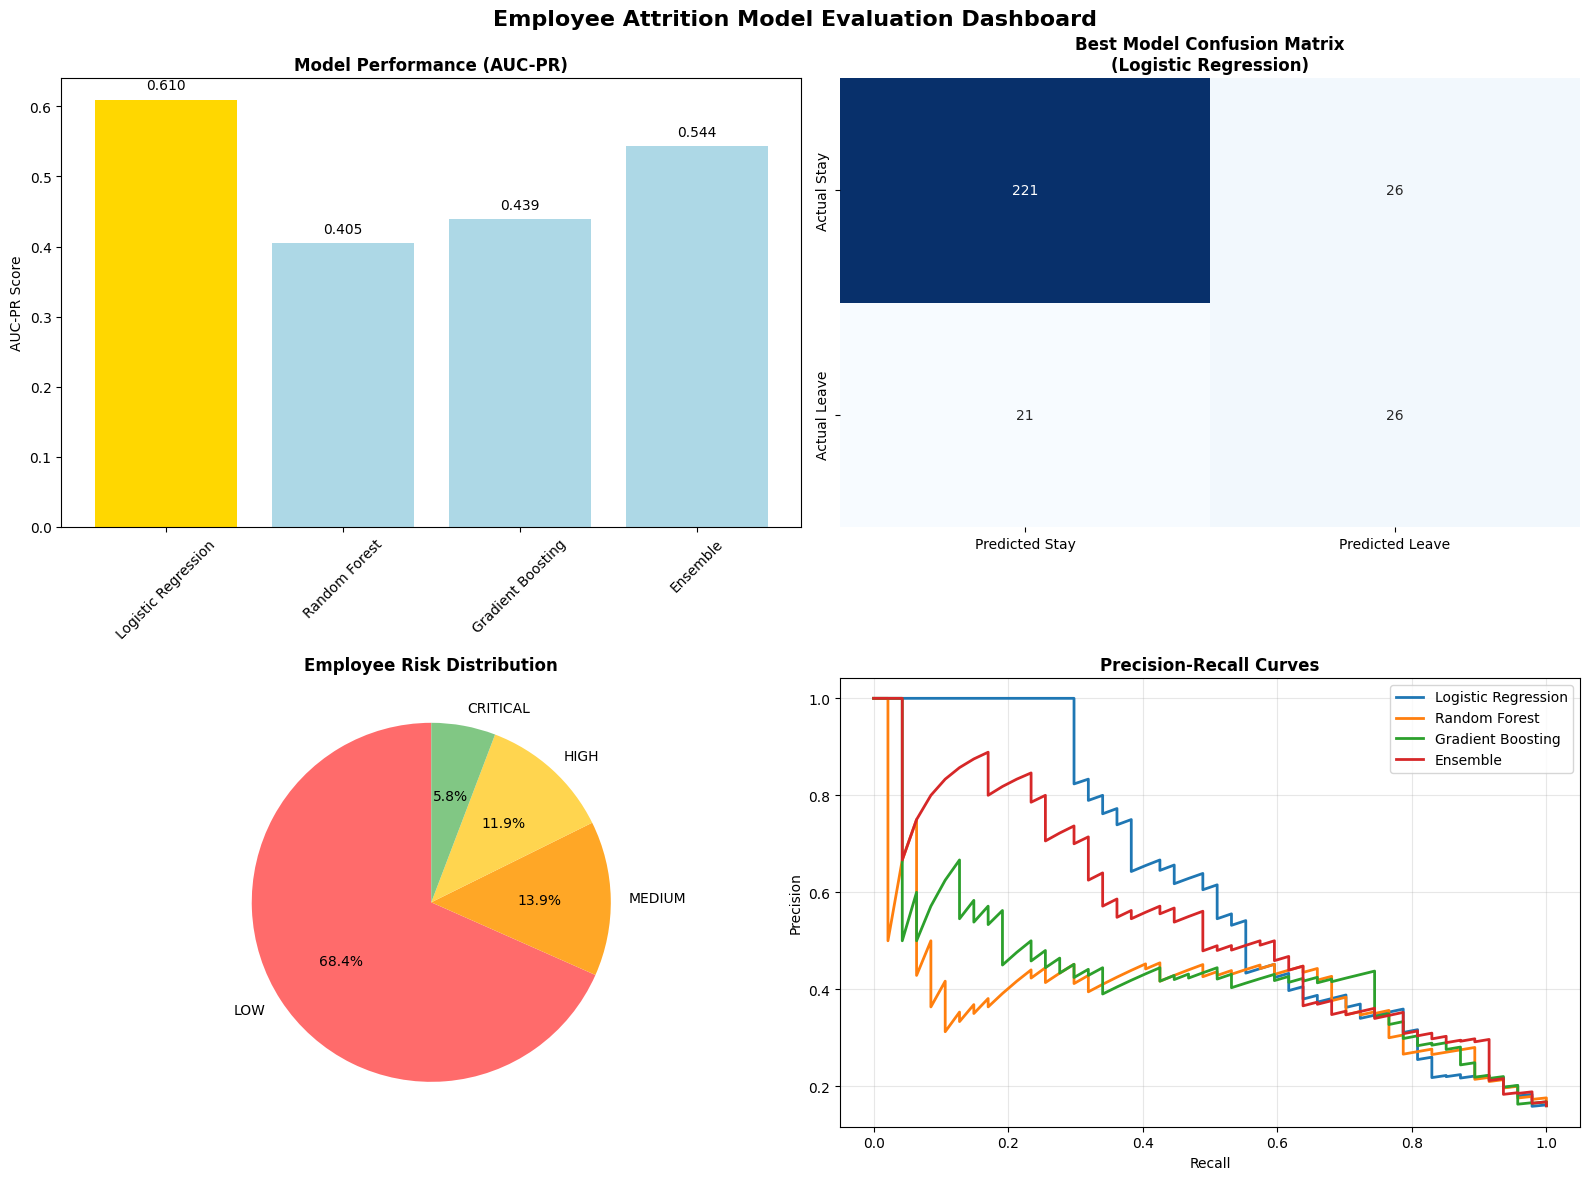

✅ Risk assessment saved to 'employee_risk_assessment.csv'
✅ Model evaluation and risk assessment completed successfully!


In [5]:
# =============================================================================
# NOTEBOOK 4: MODEL EVALUATION AND RISK ASSESSMENT
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           precision_recall_curve, average_precision_score, f1_score, accuracy_score)
import warnings
warnings.filterwarnings('ignore')

print("📊 NOTEBOOK 4: MODEL EVALUATION AND RISK ASSESSMENT")
print("=" * 50)

# Load models and data
print("📥 Loading models and data...")
models = {}
model_files = {
    'Logistic Regression': 'model_logistic_regression.pkl',
    'Random Forest': 'model_random_forest.pkl',
    'Gradient Boosting': 'model_gradient_boosting.pkl',
    'Ensemble': 'model_ensemble.pkl'
}

for name, file in model_files.items():
    try:
        models[name] = joblib.load(file)
        print(f"  ✅ Loaded {name}")
    except:
        print(f"  ❌ Could not load {name}")

X_test_scaled = joblib.load('X_test_scaled.pkl')
y_test = joblib.load('y_test.pkl')

print(f"Test set: {X_test_scaled.shape}")

# Comprehensive Model Evaluation
print("\n🎯 COMPREHENSIVE MODEL EVALUATION")
print("=" * 70)

def comprehensive_evaluation(model, X_test, y_test, model_name):
    """Comprehensive evaluation with all metrics"""
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate all metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    auc_pr = average_precision_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    # Confusion matrix details
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'f1_score': f1,
        'recall': recall,
        'precision': precision,
        'specificity': specificity,
        'confusion_matrix': cm,
        'true_positives': tp,
        'false_negatives': fn,
        'true_negatives': tn,
        'false_positives': fp,
        'y_pred_proba': y_pred_proba # Add y_pred_proba to the results
    }

# Evaluate all models
results = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    results[name] = comprehensive_evaluation(model, X_test_scaled, y_test, name)

# Display results
print("\n📈 MODEL PERFORMANCE COMPARISON:")
print("=" * 90)
print(f"{'Model':<20} {'AUC-PR':<8} {'AUC-ROC':<8} {'Recall':<8} {'Precision':<10} {'F1-Score':<8} {'Accuracy':<8}")
print("-" * 90)

best_model_name = None
best_auc_pr = 0

for name, result in results.items():
    print(f"{name:<20} {result['auc_pr']:.4f}  {result['auc_roc']:.4f}  {result['recall']:.4f}  "
          f"{result['precision']:.4f}    {result['f1_score']:.4f}  {result['accuracy']:.4f}")

    if result['auc_pr'] > best_auc_pr:
        best_auc_pr = result['auc_pr']
        best_model_name = name

print("=" * 90)
print(f"🏆 BEST MODEL: {best_model_name} (AUC-PR: {best_auc_pr:.4f})")

# Best Model Detailed Analysis
print(f"\n🔍 DETAILED ANALYSIS OF BEST MODEL: {best_model_name}")
print("=" * 60)

best_result = results[best_model_name]
best_model = models[best_model_name]

print(f"🎯 KEY PERFORMANCE METRICS:")
print(f"  • AUC-PR:        {best_result['auc_pr']:.4f}")
print(f"  • Recall:        {best_result['recall']:.4f} - Detects {best_result['recall']*100:.1f}% of actual leavers")
print(f"  • Precision:     {best_result['precision']:.4f} - {best_result['precision']*100:.1f}% of leaver predictions are correct")
print(f"  • F1-Score:      {best_result['f1_score']:.4f}")
print(f"  • Accuracy:      {best_result['accuracy']:.4f}")

print(f"\n📊 CONFUSION MATRIX:")
cm = best_result['confusion_matrix']
print(f"                   Predicted Stay   Predicted Leave")
print(f"Actual Stay        {cm[0,0]:>12}   {cm[0,1]:>14}")
print(f"Actual Leave       {cm[1,0]:>12}   {cm[1,1]:>14}")

# Risk Assessment System
print(f"\n🎯 EMPLOYEE RISK ASSESSMENT SYSTEM")
print("=" * 60)

# Calculate risk scores for all employees
risk_scores = best_model.predict_proba(X_test_scaled)[:, 1]

# Define risk tiers
def assign_risk_tier(probability):
    if probability >= 0.7:
        return "CRITICAL", "Immediate intervention required"
    elif probability >= 0.5:
        return "HIGH", "Proactive retention actions needed"
    elif probability >= 0.3:
        return "MEDIUM", "Monitor and engage regularly"
    else:
        return "LOW", "Standard engagement"

# Create risk assessment dataframe
risk_assessment = pd.DataFrame({
    'EmployeeID': X_test_scaled.index,
    'AttritionProbability': risk_scores,
    'RiskScore': (risk_scores * 100).round(1),
    'ActualAttrition': y_test.values
})

# Assign risk tiers
risk_tiers = [assign_risk_tier(score) for score in risk_scores]
risk_assessment['RiskTier'] = [tier[0] for tier in risk_tiers]
risk_assessment['RiskGuidance'] = [tier[1] for tier in risk_tiers]

# Risk distribution analysis
print("📊 RISK DISTRIBUTION ACROSS EMPLOYEES:")
risk_distribution = risk_assessment['RiskTier'].value_counts().sort_index()
for tier, count in risk_distribution.items():
    percentage = (count / len(risk_assessment)) * 100
    print(f"  • {tier:<8} Risk: {count:>3} employees ({percentage:5.1f}%)")

# Effectiveness analysis
print(f"\n🎯 RISK TIER EFFECTIVENESS:")
for tier in ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW']:
    tier_data = risk_assessment[risk_assessment['RiskTier'] == tier]
    if len(tier_data) > 0:
        actual_leavers = tier_data['ActualAttrition'].sum()
        detection_rate = (actual_leavers / len(tier_data)) * 100
        print(f"  • {tier:<8} Tier: {actual_leavers}/{len(tier_data)} actual leavers ({detection_rate:.1f}% detection rate)")

# Visualization Dashboard
print(f"\n📊 GENERATING EVALUATION DASHBOARD...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Employee Attrition Model Evaluation Dashboard', fontsize=16, fontweight='bold')

# 1. Model Performance Comparison
model_names = list(results.keys())
auc_pr_scores = [results[name]['auc_pr'] for name in model_names]
colors_perf = ['lightblue' if name != best_model_name else 'gold' for name in model_names]
bars = axes[0,0].bar(model_names, auc_pr_scores, color=colors_perf)
axes[0,0].set_title('Model Performance (AUC-PR)', fontweight='bold')
axes[0,0].set_ylabel('AUC-PR Score')
axes[0,0].tick_params(axis='x', rotation=45)
for bar, score in zip(bars, auc_pr_scores):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                  f'{score:.3f}', ha='center', va='bottom')

# 2. Confusion Matrix Heatmap
sns.heatmap(best_result['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            ax=axes[0,1], cbar=False,
            xticklabels=['Predicted Stay', 'Predicted Leave'],
            yticklabels=['Actual Stay', 'Actual Leave'])
axes[0,1].set_title(f'Best Model Confusion Matrix\n({best_model_name})', fontweight='bold')

# 3. Risk Distribution
risk_counts = risk_assessment['RiskTier'].value_counts()
colors = ['#FF6B6B', '#FFA726', '#FFD54F', '#81C784']
axes[1,0].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
              colors=colors, startangle=90)
axes[1,0].set_title('Employee Risk Distribution', fontweight='bold')

# 4. Precision-Recall Curve
for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['y_pred_proba'])
    axes[1,1].plot(recall, precision, label=name, linewidth=2)
axes[1,1].set_xlabel('Recall')
axes[1,1].set_ylabel('Precision')
axes[1,1].set_title('Precision-Recall Curves', fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_evaluation_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

# Save risk assessment
risk_assessment.to_csv('employee_risk_assessment.csv', index=False)
print("✅ Risk assessment saved to 'employee_risk_assessment.csv'")

print("✅ Model evaluation and risk assessment completed successfully!")